# Тестирование производительности
## Описание экспериментов
Данный блокнот сделан с целью выявления наилучших параметров по умолчанию для оптимизации динамической регрессии. Будут подбираться следующие параметры:
- `learning_steps`
- `ar_depth`
- `seas_depth`
- `fit_intercept`
- `tolerance`
- `max_iter`
- стартовый набор параметров
- `lr_finder`

Параметры будут выбираться поочерёдно. Сначала набор параметров будет зафиксирован следующий:
- `learning_steps = 'all'`
- `ar_depth = 5`
- `seas_depth = 2`
- `fit_intercept = True`
- `tolerance = 1e-3`
- `max_iter = 1000000`
- стартовый набор параметров -- случайный
- `lr_finder = Wolfe`

В качестве данных я возьму 6 рядов разной сезонности и длины из датасета M4: H1, D1, W1, Q1, M1. Прогнозировать буду на `fh=5`. Последние 5 значений ряда будут отрезаться и использоваться как тестовая выборка.

В каждой новой части эксперимента я буду подбирать отдельным способом новый параметр. Предыдущие параметры будут фиксироваться (заново) и считаться выбранными. Для каждого параметра будут строиться графики времени сходимости градиентного спуска и качества на тестовой выборке в зависимости от значения параметра. Общее правило при выборе параметров -- мы хотим выбрать параметры с максимальным качеством при минимальном времени.

## Эксперименты

Импортируем нужные библиотеки:

In [1]:
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from dynamic_regression import DynamicRegression
from models import SktimeETS, SktimeARIMA, SktimeLinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_squared_error


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.9/site-packages/sktime/utils/validation/series.py:22: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/usr/local/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:25: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  RELATIVE_TYPES = (pd.Int64Index, pd.RangeIndex, pd.TimedeltaIndex)
/usr/local/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:26: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ABSOLUTE_TYPES = (pd.Int64Index, pd.RangeIndex, pd.DatetimeIndex, pd.PeriodIndex)
/usr/local/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed f

In [2]:
columns = ["H1", "D1", "W1", "M1", "Q1", "Y1"]
dataset = pd.DataFrame(columns=columns)
for column in columns:
    if column.startswith("H"):
        cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Hourly-train.csv")
    elif column.startswith("D"):
        cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Daily-train.csv")
    elif column.startswith("W"):
        cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Weekly-train.csv")
    elif column.startswith("M"):
        cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Monthly-train.csv")
    elif column.startswith("Q"):
        cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Quarterly-train.csv")
    elif column.startswith("Y"):
        cur_dataset = pd.read_csv("/Users/beast-sl/source/repos/coursework-3/Dataset/Train/Yearly-train.csv")
    series = cur_dataset[cur_dataset["V1"] == column].squeeze().dropna().drop(index='V1').astype(np.float64)
    series.index = range(len(series))
    series = series.reindex(range(2179))
    dataset[column] = series
dataset

,H1,D1,W1,M1,Q1,Y1
0,605.0,1017.1,1089.20,8000.0,7407.412314,5172.1
1,586.0,1019.3,1078.91,8350.0,7528.566074,5133.5
2,586.0,1017.0,1079.88,8570.0,7374.709225,5186.9
3,559.0,1019.2,1063.58,7700.0,7395.514848,5084.6
4,511.0,1018.7,1060.61,7080.0,7654.007989,5182.0
...,...,...,...,...,...,...
2174,NaN,NaN,38429.93,NaN,NaN,NaN
2175,NaN,NaN,38429.93,NaN,NaN,NaN
2176,NaN,NaN,36565.18,NaN,NaN,NaN
2177,NaN,NaN,36565.18,NaN,NaN,NaN


### `learning_steps`

Я вижу два разумных значения для параметра `learning_steps` -- это значение `'all'` и значение, равное `fh`. Слева на графике `'all'`, справа `fh`.

Processing series H1
Processing series D1
Processing series W1
Processing series M1
Series M1 did not converge with learning_steps all
Tolerance is 0.04106910689718211
Processing series Q1
Series Q1 did not converge with learning_steps all
Tolerance is 0.051658966321669636
Processing series Y1


Text(0.5, 1.0, 'MSE on test depending on learning_steps')

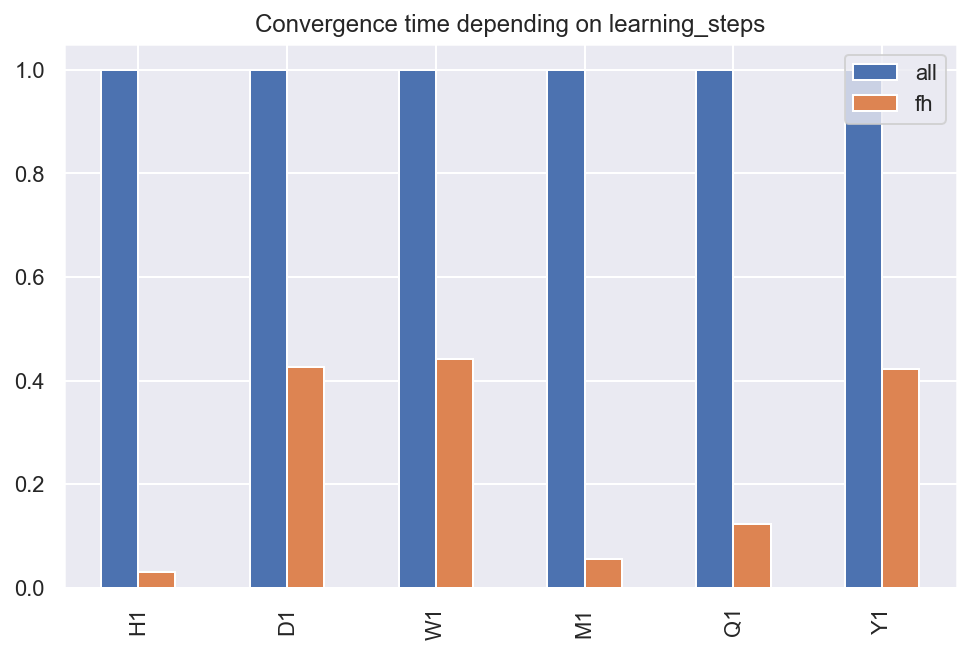

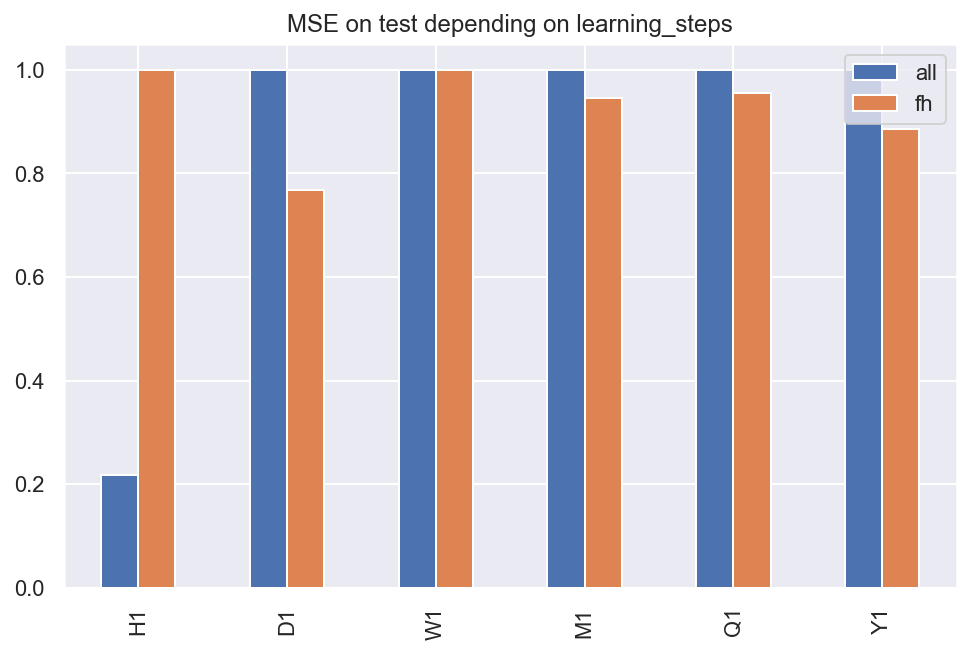

In [19]:
fh = np.array([5])
choices = ['all', np.array([5])]
ticklabels = ['all', 'fh']
df_times = pd.DataFrame(index=ticklabels, columns=columns)
df_errors = pd.DataFrame(index=ticklabels, columns=columns)
for series in columns:
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    times = []
    errors = []
    print(f"Processing series {series}")
    for learning_steps in choices:
        model = DynamicRegression(fh=[5], learning_steps=learning_steps)
        status, history = model.fit(train, trace=True)
        if status == 'iterations_exceeded':
            print(f"Series {series} did not converge with learning_steps {learning_steps}")
            print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
        times.append(history['time'][-1])
        errors.append(mean_squared_error([test[fh - 1]], model.predict(train)))
    df_times[series] = times
    df_errors[series] = errors
normalized_df_times = (df_times)/df_times.max()
normalized_df_errors = (df_errors)/df_errors.max()
ax1 = normalized_df_times.transpose().plot.bar()
ax1.set_title("Convergence time depending on learning_steps (normalized)")
ax2 = normalized_df_errors.transpose().plot.bar()
ax2.set_title("MSE on test depending on learning_steps (normalized")

Мы видим, что метод `fh` проиграл по MSE только на ряду H1, но на всех остальных либо не проиграл, либо выиграл. При этом `fh` намного быстрее на всех рядах. Поэтому правильно взять `learning_steps=fh`.

### `ar_depth`

Параметр `ar_depth` будет подбираться среди значений [1, 5, 10, 15, 20, 25, 30].

Processing series H1
Processing series D1
Processing series W1
Processing series M1
Processing series Q1
Processing series Y1


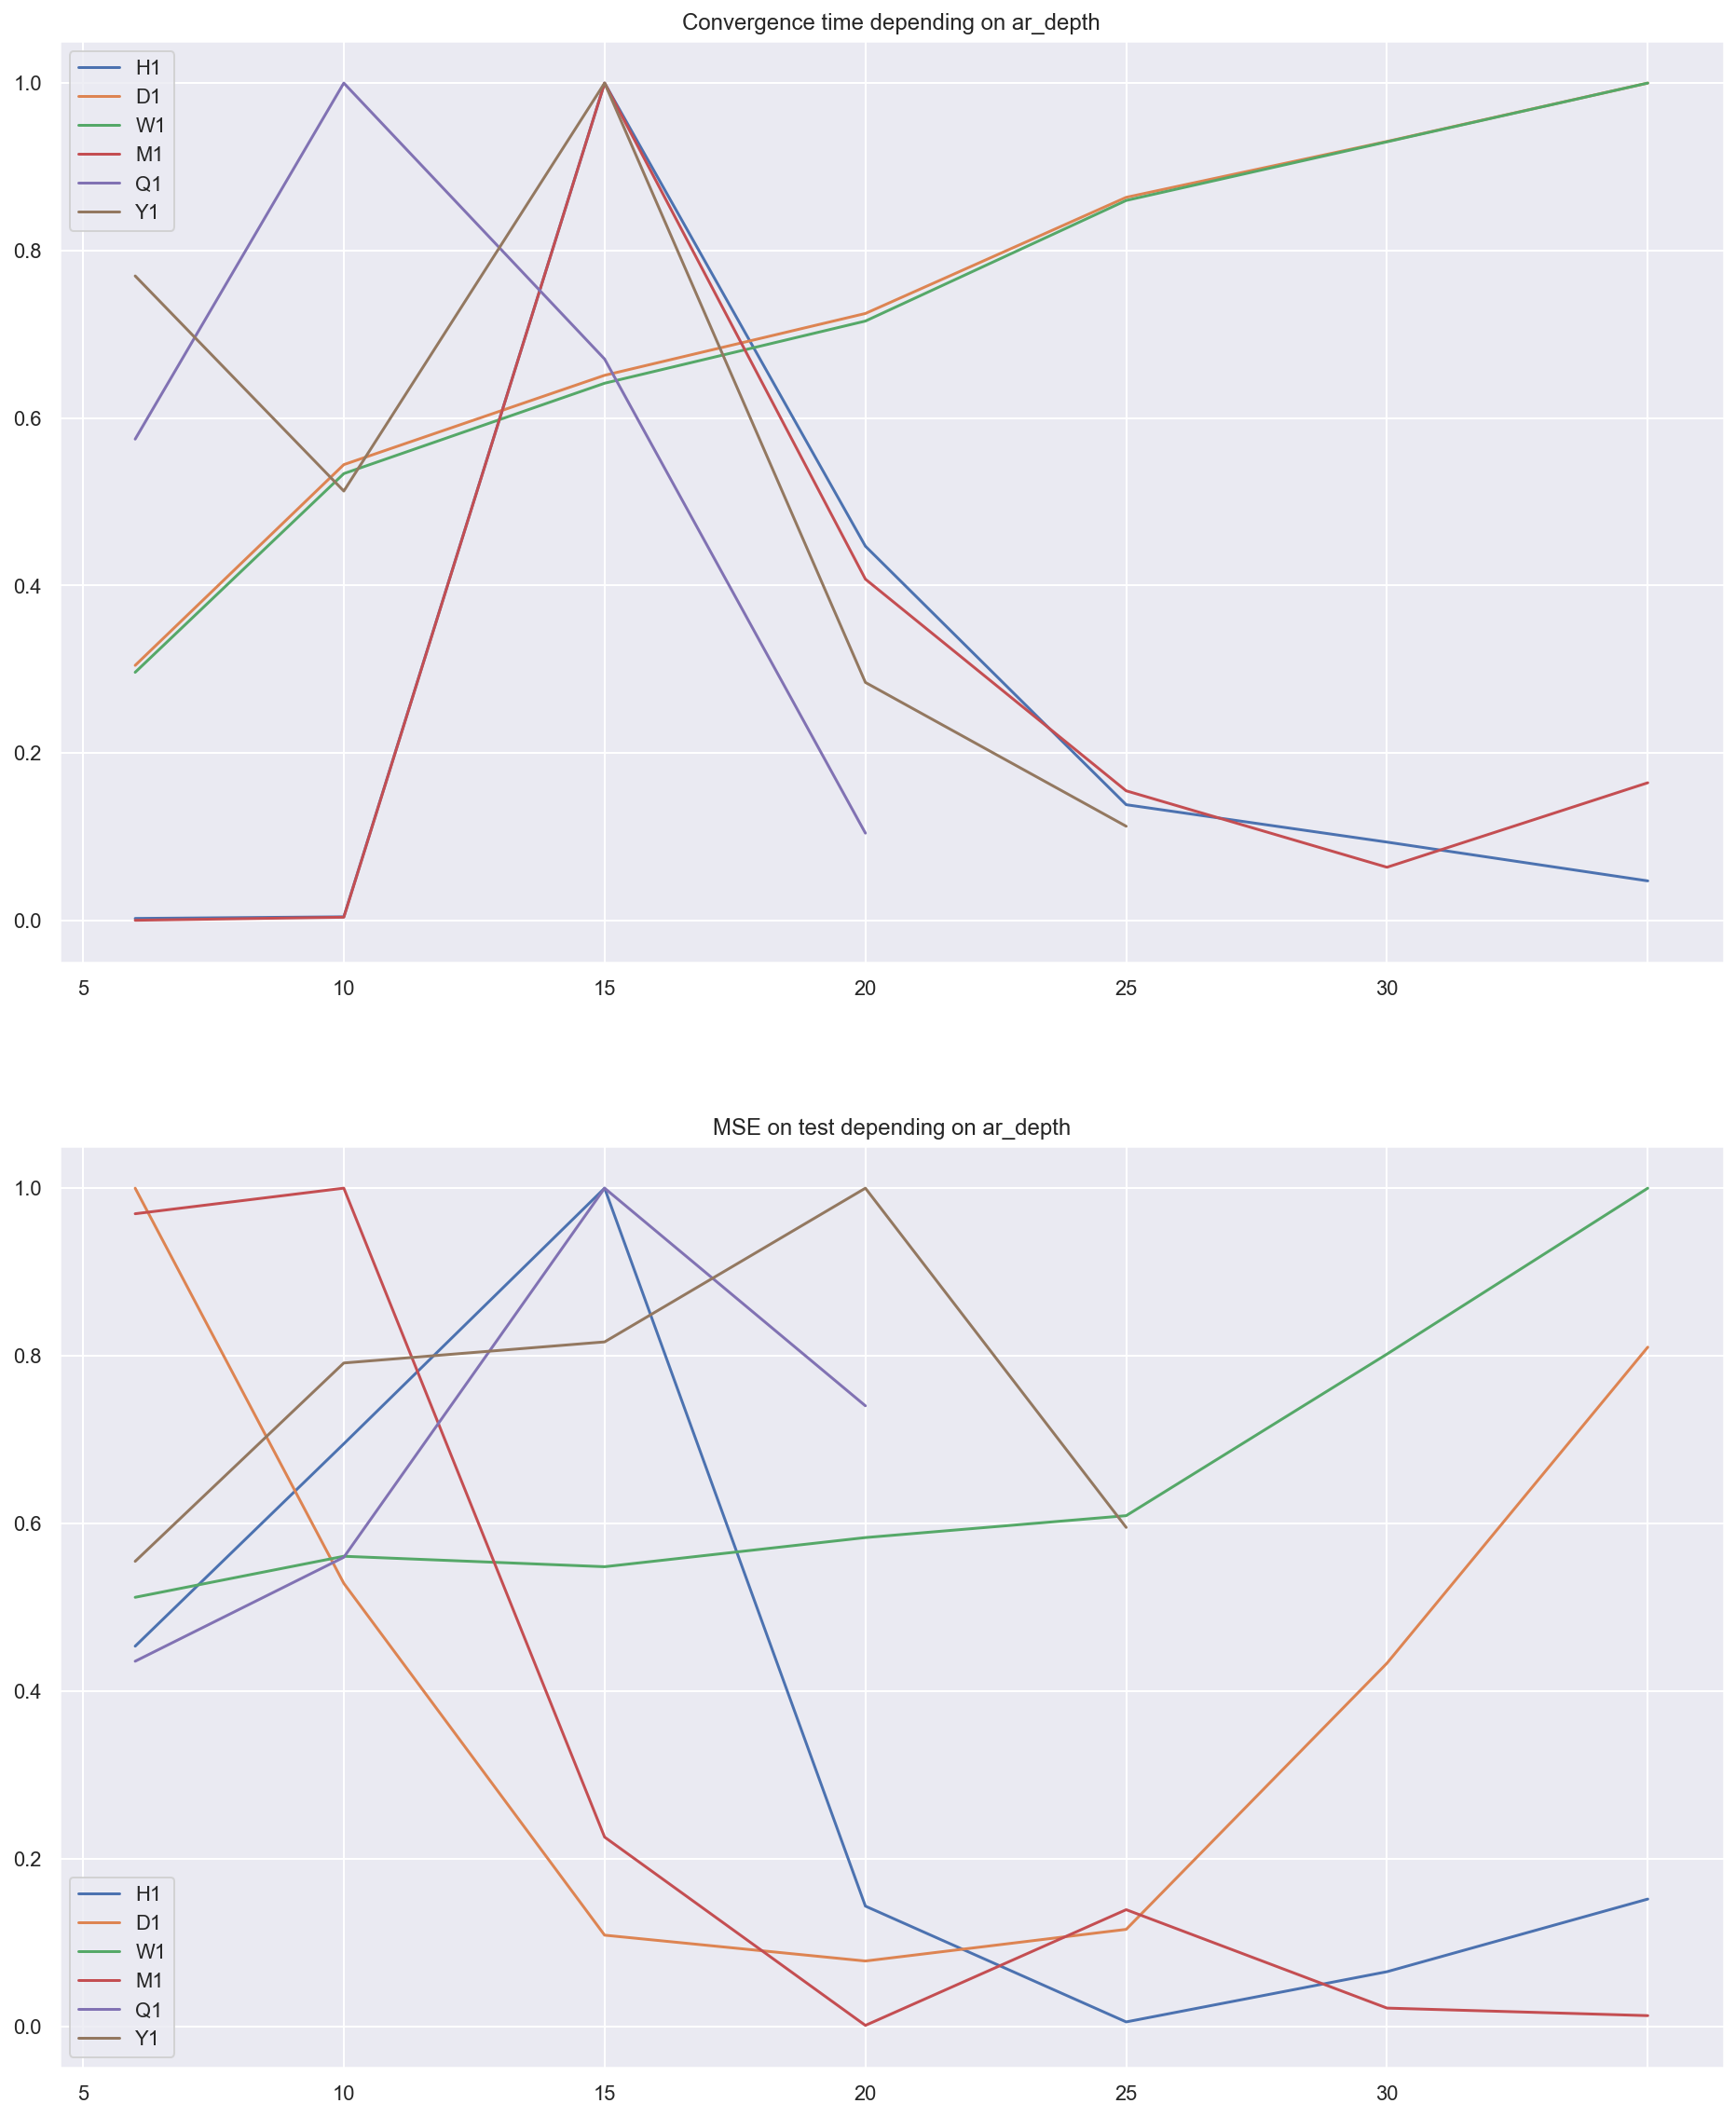

In [4]:
fh = np.array([5])
choices = [1, 5, 10, 15, 20, 25, 30]
fig, ((ax1), (ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(16, 20))
ax1.set_title("Convergence time depending on ar_depth")
ax1.set_xticklabels(choices)
ax2.set_title("MSE on test depending on ar_depth")
ax2.set_xticklabels(choices)
for series in columns:
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    times = []
    errors = []
    x = []
    print(f"Processing series {series}")
    for ar_depth in choices:
        if ar_depth + 5 > train.shape[0]:
            continue
        model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=ar_depth)
        status, history = model.fit(train, trace=True)
        if status == 'iterations_exceeded':
            print(f"Series {series} did not converge with ar_depth {ar_depth}")
            print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
        times.append(history['time'][-1])
        errors.append(mean_squared_error([test[fh - 1]], model.predict(train)))
        x.append(ar_depth)
    times = np.array(times)
    errors = np.array(errors)
    ax1.plot(x, times / times.max(), label=series)
    ax2.plot(x, errors / errors.max(), label=series)
ax1.legend()
ax2.legend()
plt.show()


Мы видим, что при параметре `ar_depth=1` мы получаем лучшие значения MSE на тестирующей выборке для половины рядов. Ещё для двух лучшее значение -- 15, ещё для одного -- 20. Поэтому предлагаю взять за дефолт `ar_depth=1`.

### `seas_depth`

В данном эксперименте будет тестироваться сезонная динамическая регрессия. Ряд Y1 не будет рассмотрен. Параметры `sp` для разных сезонностей рядов:
- H: 24
- D: 30
- W: 4
- Q: 4
- M: 12

Параметр `seas_depth` будет подбираться среди значений [1, 2, 3, 4].

Processing series H1
Processing series D1
Processing series W1
Processing series M1
Processing series Q1


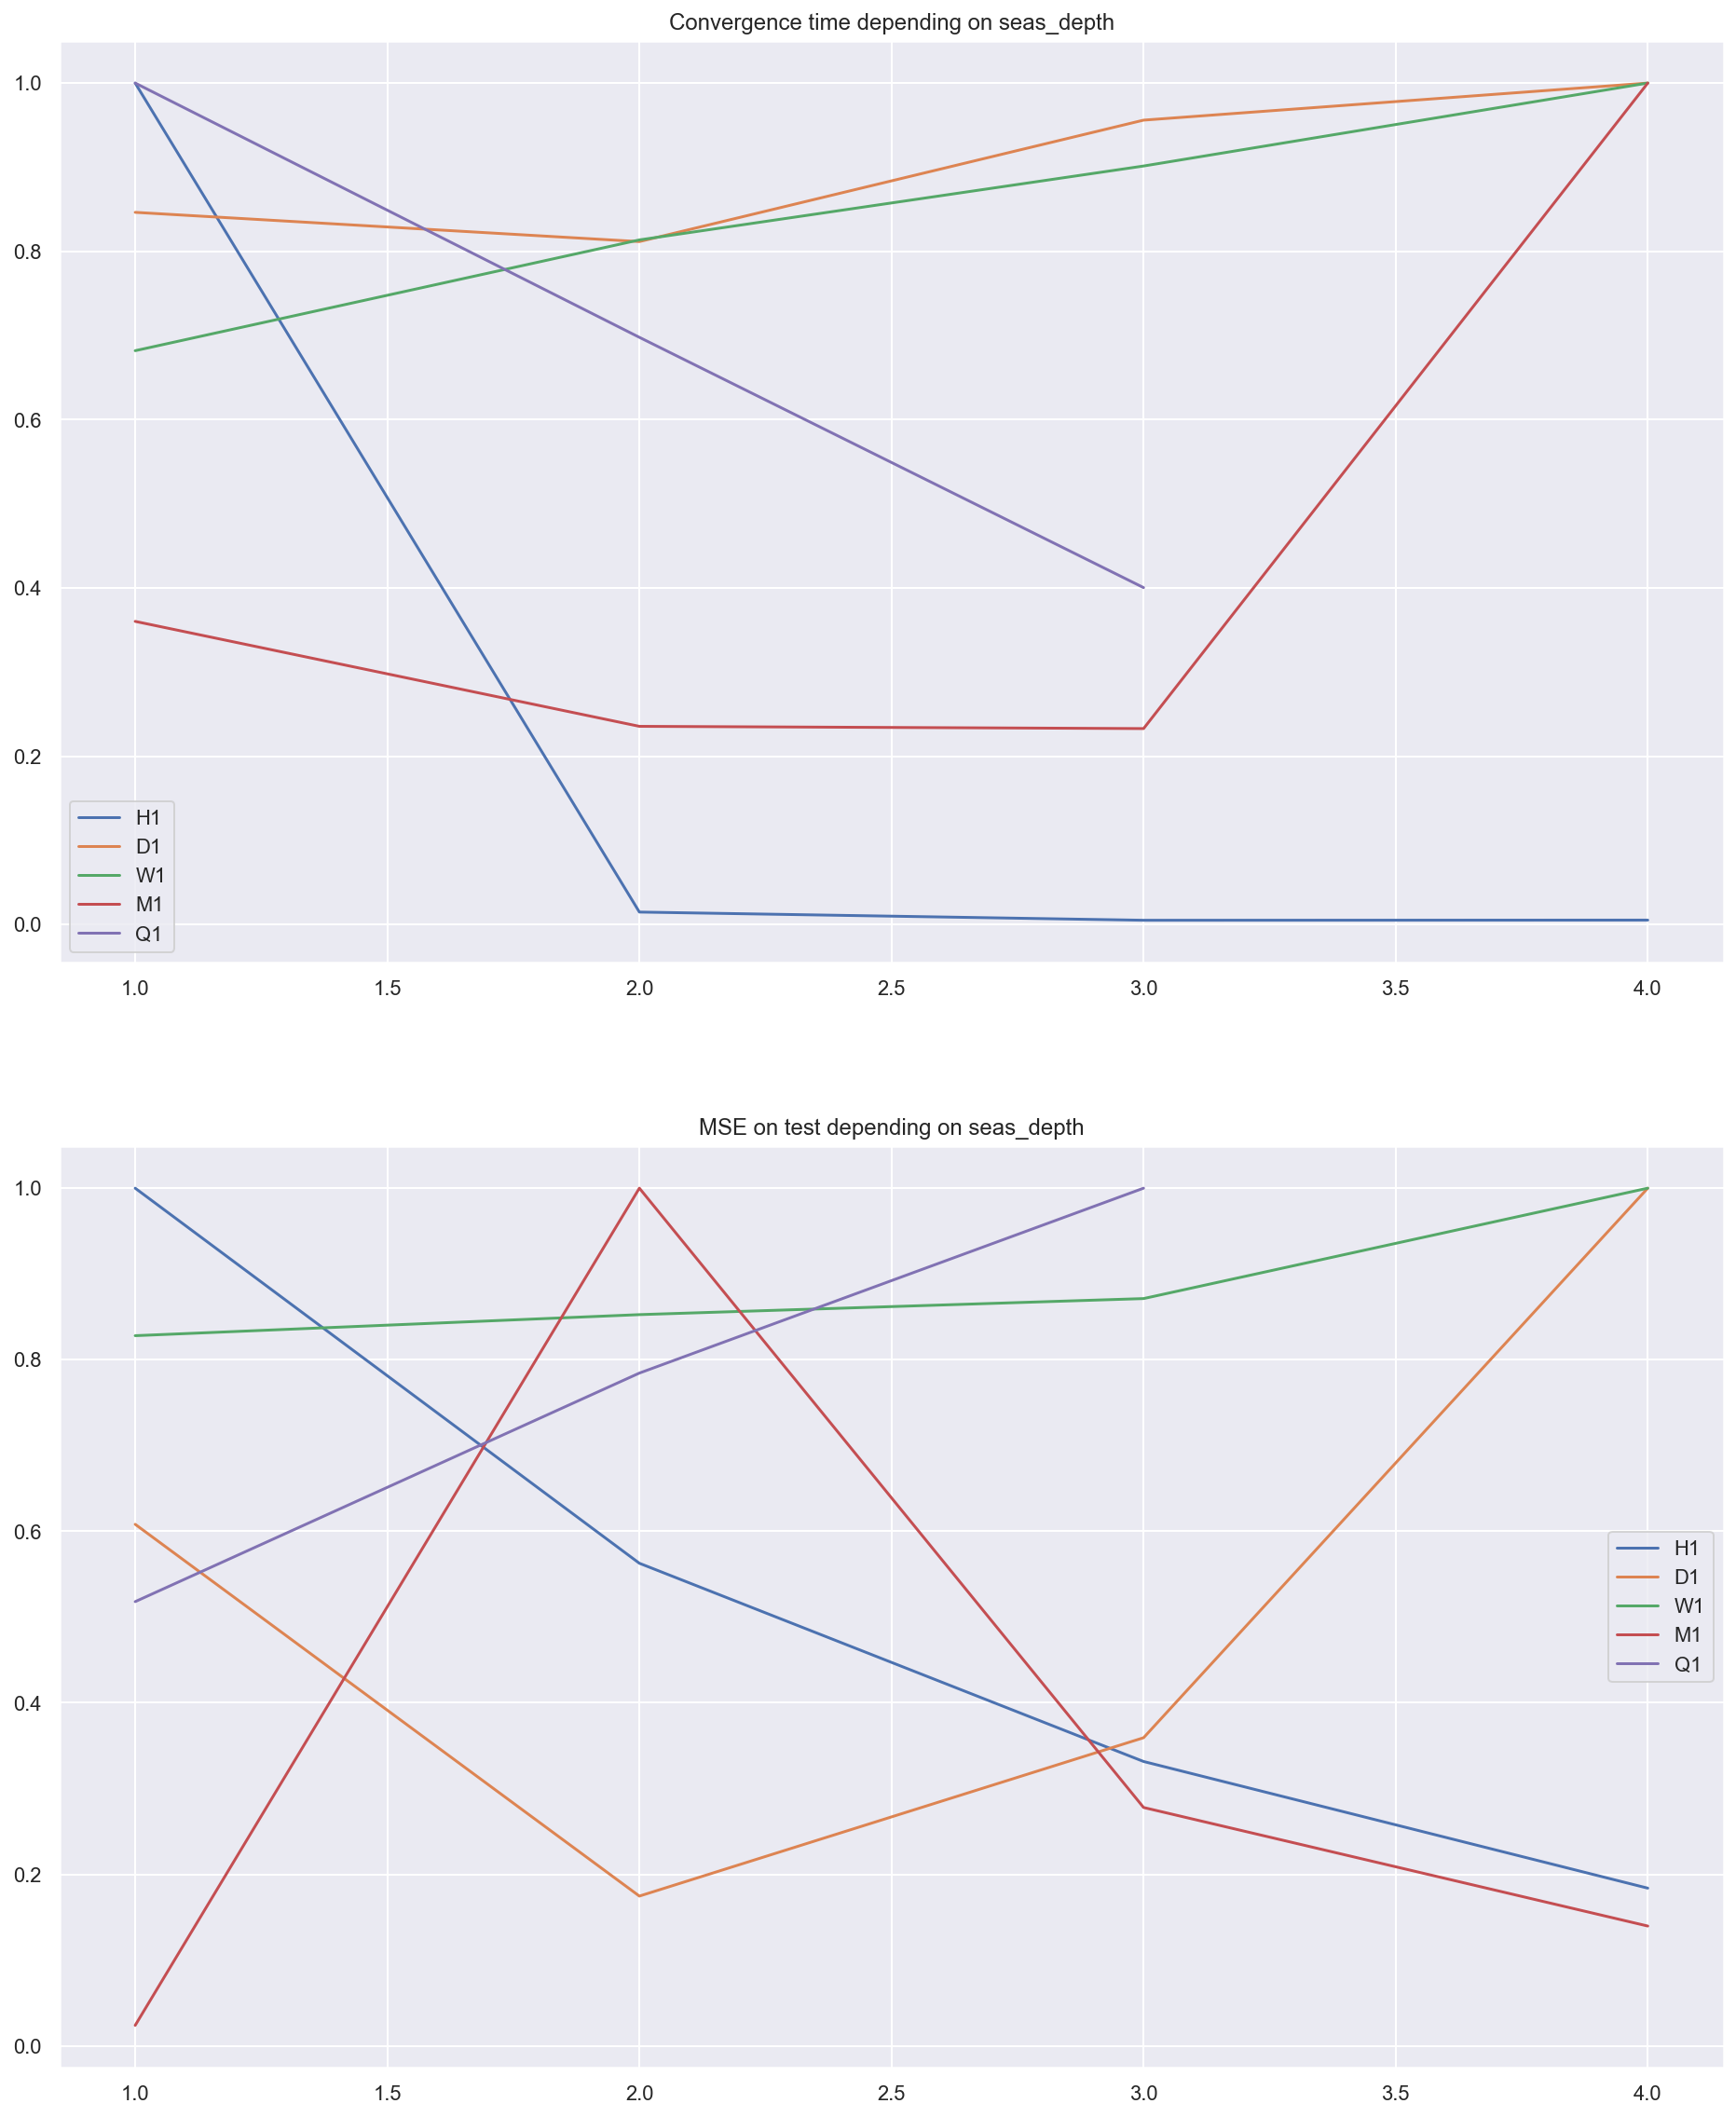

In [7]:
fh = np.array([5])
choices = [1, 2, 3, 4]
sps = {
    'H1': 24,
    'D1': 30,
    'W1': 4,
    'Q1': 4,
    'M1': 12
}
cur_columns = columns[:-1]
fig, ((ax1), (ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(16, 20))
ax1.set_title("Convergence time depending on seas_depth")
ax2.set_title("MSE on test depending on seas_depth")
for series in cur_columns:
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    times = []
    errors = []
    x = []
    print(f"Processing series {series}")
    for seas_depth in choices:
        if sps[series] * seas_depth + 5 > train.shape[0]:
            continue
        model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=1, sp=sps[series], seas_depth=seas_depth)
        status, history = model.fit(train, trace=True)
        if status == 'iterations_exceeded':
            print(f"Series {series} did not converge with seas_depth {seas_depth}")
            print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
        x.append(seas_depth)
        times.append(history['time'][-1])
        errors.append(mean_squared_error([test[fh - 1]], model.predict(train)))
    times = np.array(times)
    errors = np.array(errors)
    ax1.plot(x, times / times.max(), label=series)
    ax2.plot(x, errors / errors.max(), label=series)
ax1.legend()
ax2.legend()
plt.show()

Для трёх рядов оптимальным `seas_depth` оказался 1, для одного -- 2, для одного -- 4. Таким образом, `seas_depth=1` оказывается лучшим вариантом.

### `fit_intercept`

Параметр `fit_intercept` будет подбираться среди значений [True, False]. Слева значение False, справа значение True.

Processing series H1
Processing series D1
Processing series W1
Processing series M1
Processing series Q1
Processing series Y1


Text(0.5, 1.0, 'MSE on test depending on fit_intercept (normalized')

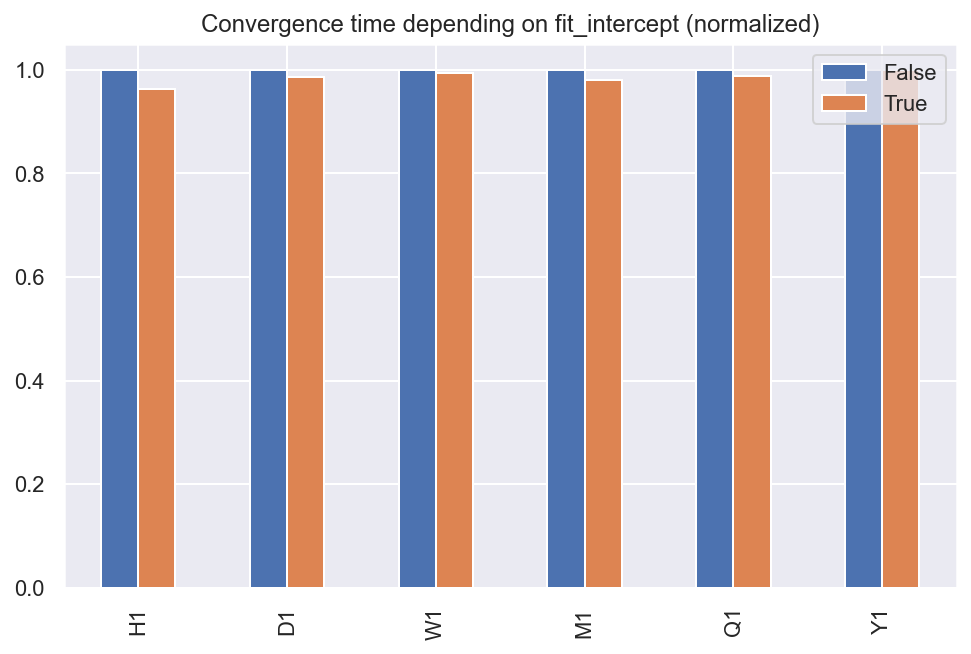

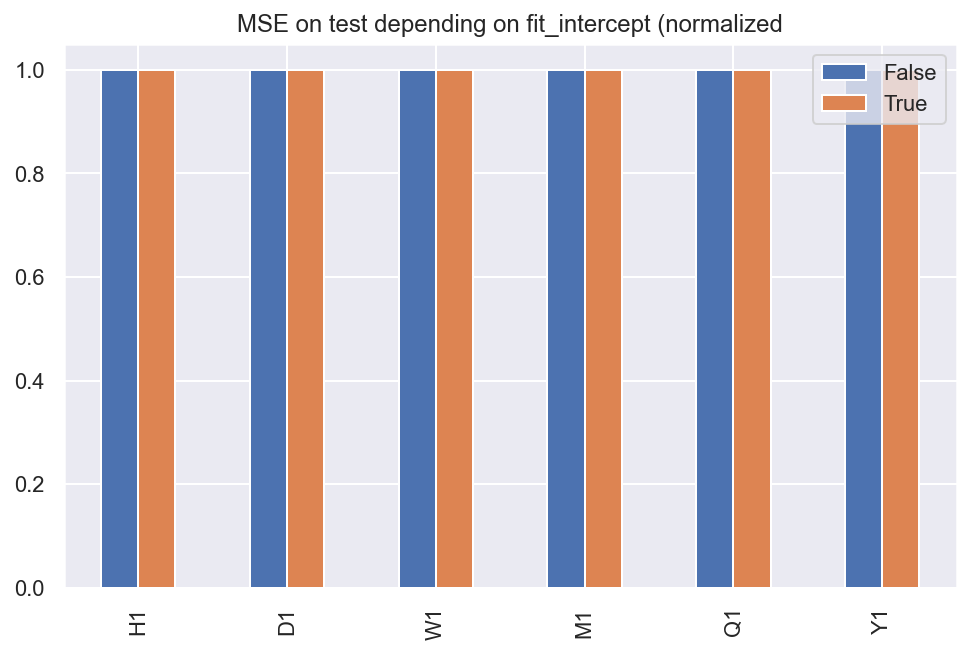

In [10]:
fh = np.array([5])
choices = [False, True]
df_times = pd.DataFrame(index=choices, columns=columns)
df_errors = pd.DataFrame(index=choices, columns=columns)
for series in columns:
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    times = []
    errors = []
    print(f"Processing series {series}")
    for fit_intercept in choices:
        model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=1, fit_intercept=fit_intercept)
        status, history = model.fit(train, trace=True)
        if status == 'iterations_exceeded':
            print(f"Series {series} did not converge with fit_intercept {fit_intercept}")
            print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
        times.append(history['time'][-1])
        errors.append(mean_squared_error([test[fh - 1]], model.predict(train)))
    df_times[series] = times
    df_errors[series] = errors
normalized_df_times = (df_times)/df_times.max()
normalized_df_errors = (df_errors)/df_errors.max()
ax1 = normalized_df_times.transpose().plot.bar()
ax1.set_title("Convergence time depending on fit_intercept (normalized)")
ax2 = normalized_df_errors.transpose().plot.bar()
ax2.set_title("MSE on test depending on fit_intercept (normalized")

В этом случае по MSE более-менее одинаковые варианты, но по времени немного выигрывает вариант с fit_intercept=True. Поэтому будем фиттить.

### `tolerance`

Параметр `tolerance` будет подбираться по логарифмической сетке между значениями [1, 1e-8].

Processing series H1
Series H1 did not converge with tolerance 1e-06
Tolerance is 1.3141522241173761e-05
Processing series D1
Processing series W1
Processing series M1
Series M1 did not converge with tolerance 1e-08
Tolerance is 1.5797289162210653e-07
Processing series Q1
Processing series Y1
{1.0: 0, 0.1: 0, 0.01: 0, 0.001: 0, 0.0001: 0, 1e-05: 0, 1e-06: 1, 1e-07: 0, 1e-08: 1}


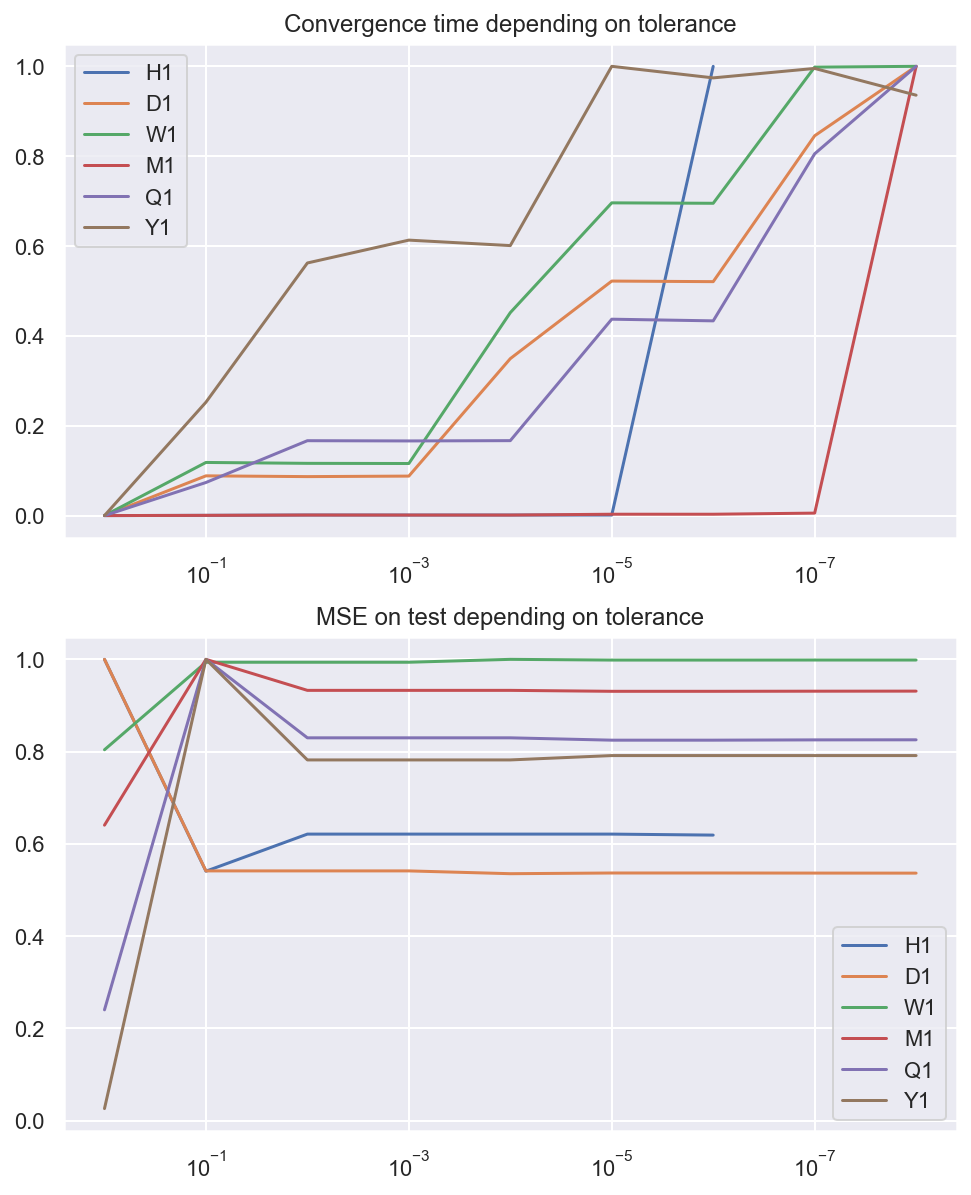

In [13]:
fh = np.array([5])
choices = np.logspace(-8, 0, 9)[::-1]
fig, ((ax1), (ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
ax1.set_title("Convergence time depending on tolerance")
ax1.invert_xaxis()
ax1.set_xscale('log')
ax2.set_title("MSE on test depending on tolerance")
ax2.invert_xaxis()
ax2.set_xscale('log')
convergence_failures = {key: 0 for key in choices}
for series in columns:
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    times = []
    errors = []
    x = []
    print(f"Processing series {series}")
    broken = False
    for tolerance in choices:
        if broken:
            continue
        model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=1, tolerance=tolerance, max_iter=1000)
        status, history = model.fit(train, trace=True)
        if status == 'iterations_exceeded':
            print(f"Series {series} did not converge with tolerance {tolerance}")
            print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            convergence_failures[tolerance] += 1
            broken=True
        x.append(tolerance)
        times.append(history['time'][-1])
        errors.append(mean_squared_error([test[fh - 1]], model.predict(train)))
    times = np.array(times)
    errors = np.array(errors)
    ax1.plot(x, times / times.max(), label=series)
    ax2.plot(x, errors / errors.max(), label=series)
ax1.legend()
ax2.legend()
print(convergence_failures)
plt.show()

Вообще говоря, судя по всему, очень быстро переобучается модель, но взять `tolerance=1` означало бы не использовать динамическую регрессию. Среди остальных при tolerance=0.01 мы видим улучшение на половине рядов, боковой тренд на двух и ухудшение на одном. Поэтому я думаю, что правильно взять `tolerance=0.01`.

### `max_iter`

Это единственный необычный эксперимент. Цель `max_iter` -- быть достаточно большим, чтобы удовлетворять сходимости до нужного `tolerance` и не быть больше, поэтому здесь я буду считать только долю сошедшихся запусков градиентного спуска по логарифмической сетке среди значений [10, 1000000]. Выберу минимальный, на котором все или почти все ряды сойдутся.

In [15]:
fh = np.array([5])
choices = np.logspace(0, 6, 7).astype(int)
convergence_failures = {key: 0 for key in choices}
for series in columns:
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    times = []
    errors = []
    print(f"Processing series {series}")
    for max_iter in choices:
        model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=1, max_iter=max_iter)
        status, history = model.fit(train, trace=True)
        if status == 'iterations_exceeded':
            print(f"Series {series} did not converge with max_iter {max_iter}")
            print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            convergence_failures[max_iter] += 1
print(convergence_failures)

Processing series H1
Series H1 did not converge with max_iter 1
Tolerance is 0.05769624185598849
Processing series D1
Processing series W1
Processing series M1
Series M1 did not converge with max_iter 1
Tolerance is 0.04300571762937249
Processing series Q1
Series Q1 did not converge with max_iter 1
Tolerance is 0.044933402240590295
Processing series Y1
Series Y1 did not converge with max_iter 1
Tolerance is 0.026480586336324434
{1: 4, 10: 0, 100: 0, 1000: 0, 10000: 0, 100000: 0, 1000000: 0}


При `max_iter=10` уже всё сходится к нужной `tolerance`, так что возьмём его по умолчанию.

### Стартовый набор параметров

Я вижу три разумных метода выбора набора параметров:
- Случайный, отнормированный так, чтобы сумма была равна 1.
- Равный частным автокорреляциям с лагами.
- Равный частным автокорреляциям с лагами, отнормированный так, чтобы сумма была равна 1.


Processing series H1
Processing series D1
Processing series W1
Processing series M1
Processing series Q1
Processing series Y1


Text(0.5, 1.0, 'MSE on test depending on starting_params (normalized')

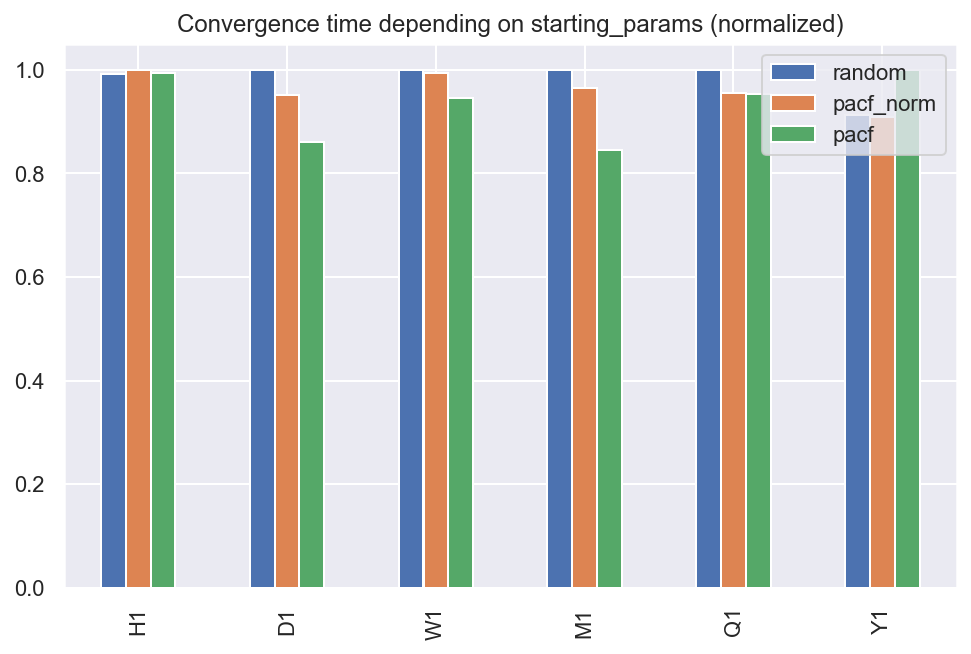

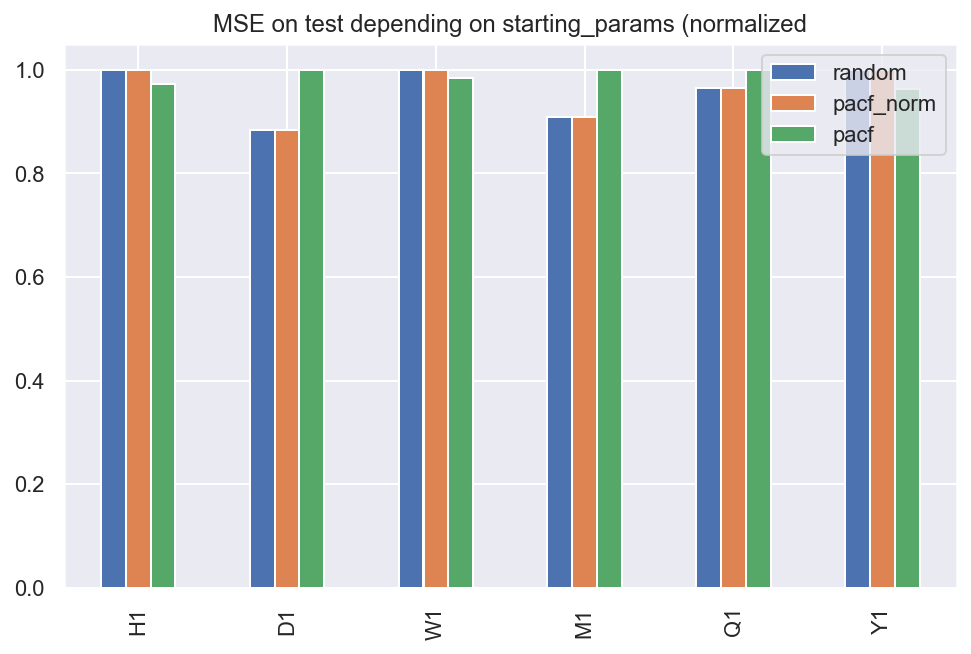

In [17]:
fh = np.array([5])
choices = ['random', 'pacf_norm', 'pacf']
convergence_failures = {key: 0 for key in choices}
df_times = pd.DataFrame(index=choices, columns=columns)
df_errors = pd.DataFrame(index=choices, columns=columns)
for series in columns:
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    times = []
    errors = []
    print(f"Processing series {series}")
    for starting_params in choices:
        model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=1, max_iter=10)
        status, history = model.fit(train, trace=True, starting_params=starting_params)
        if status == 'iterations_exceeded':
            print(f"Series {series} did not converge with starting_params {starting_params}")
            print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            convergence_failures[starting_params] += 1
        times.append(history['time'][-1])
        errors.append(mean_squared_error([test[fh - 1]], model.predict(train)))
    df_times[series] = times
    df_errors[series] = errors
    ax1.plot(choices, times, label=series)
    ax2.plot(choices, errors, label=series)
normalized_df_times = (df_times)/df_times.max()
normalized_df_errors = (df_errors)/df_errors.max()
ax1 = normalized_df_times.transpose().plot.bar()
ax1.set_title("Convergence time depending on starting_params (normalized)")
ax2 = normalized_df_errors.transpose().plot.bar()
ax2.set_title("MSE on test depending on starting_params (normalized")

При `ar_depth=1` понятно, что параметры `random` и `pacf_norm` совпадают и равны 1 (оба они лучше чем `pacf` по MSE на тестирующей выборке). Поэтому давайте попробуем с `ar_depth=15`:

Processing series H1
Series H1 did not converge with starting_params random
Tolerance is 0.15846236955103554
Series H1 did not converge with starting_params pacf
Tolerance is 0.05374847468487845
Processing series D1
Processing series W1
Series W1 did not converge with starting_params pacf_norm
Tolerance is 0.45011519079613665
Processing series M1
Series M1 did not converge with starting_params random
Tolerance is 0.6085766969327594
Series M1 did not converge with starting_params pacf_norm
Tolerance is 0.6220053207934755


Text(0.5, 1.0, 'MSE on test depending on starting_params (normalized')

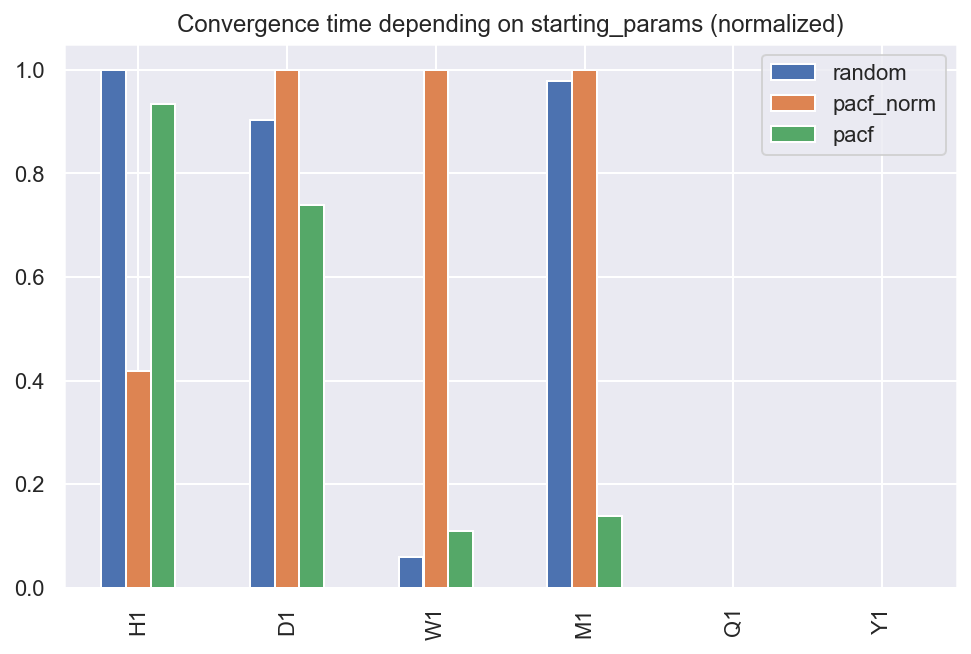

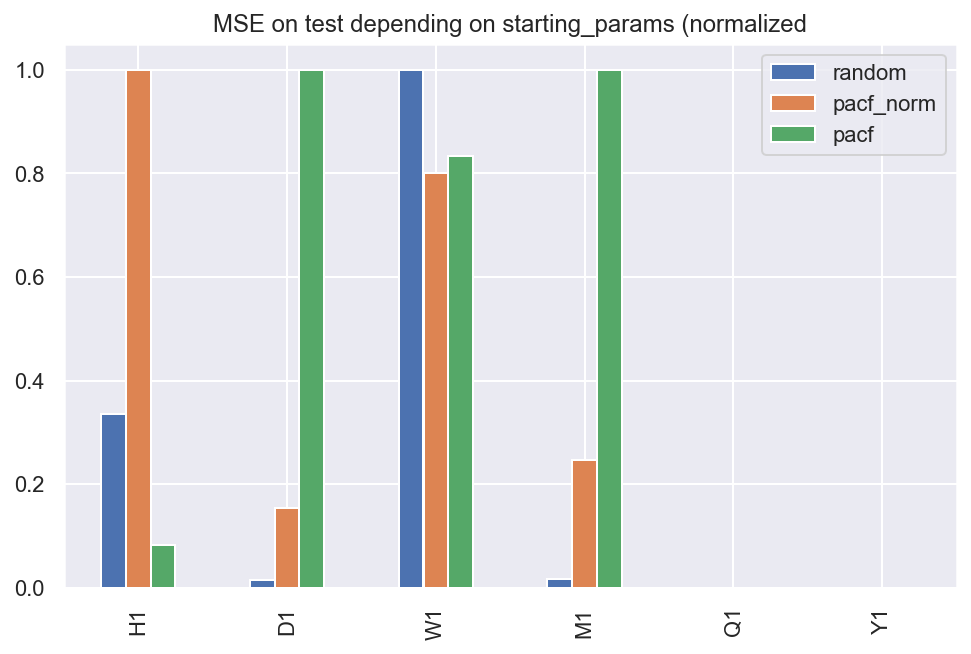

In [22]:
fh = np.array([5])
choices = ['random', 'pacf_norm', 'pacf']
convergence_failures = {key: 0 for key in choices}
df_times = pd.DataFrame(index=choices, columns=columns)
df_errors = pd.DataFrame(index=choices, columns=columns)
cur_columns = ['H1','D1','W1','M1']
for series in cur_columns:
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    times = []
    errors = []
    print(f"Processing series {series}")
    for starting_params in choices:
        model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=15, max_iter=10)
        status, history = model.fit(train, trace=True, starting_params=starting_params)
        if status == 'iterations_exceeded':
            print(f"Series {series} did not converge with starting_params {starting_params}")
            print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            convergence_failures[starting_params] += 1
        times.append(history['time'][-1])
        errors.append(mean_squared_error([test[fh - 1]], model.predict(train)))
    df_times[series] = times
    df_errors[series] = errors
    ax1.plot(choices, times, label=series)
    ax2.plot(choices, errors, label=series)
normalized_df_times = (df_times)/df_times.max()
normalized_df_errors = (df_errors)/df_errors.max()
ax1 = normalized_df_times.transpose().plot.bar()
ax1.set_title("Convergence time depending on starting_params (normalized)")
ax2 = normalized_df_errors.transpose().plot.bar()
ax2.set_title("MSE on test depending on starting_params (normalized")

По MSE лучшим параметром всё-таки кажется `random`. При этом видно, что пара рядов не сошлась, но главное что MSE хороший. Так что возьмём его.

### `lr_finder`

Здесь есть четыре способа:
- Constant с $\alpha = 10^{-3}$;
- Formula, `starting_alpha=5e-3`;
- Armijo, стартовый $\alpha = 1$;
- Wolfe, стартовый $\alpha = 1$.

Processing series H1
Processing series D1
Series D1 did not converge with lr_finder Constant
Tolerance is 1.0000000000143545
Processing series W1
Series W1 did not converge with lr_finder Constant
Tolerance is 0.05153890454970631
Series W1 did not converge with lr_finder Formula
Tolerance is 0.059267547305932006
Processing series M1
Processing series Q1
Processing series Y1
Series Y1 did not converge with lr_finder Constant
Tolerance is 0.15168716214179256


Text(0.5, 1.0, 'Convergence time depending on starting_params (normalized)')

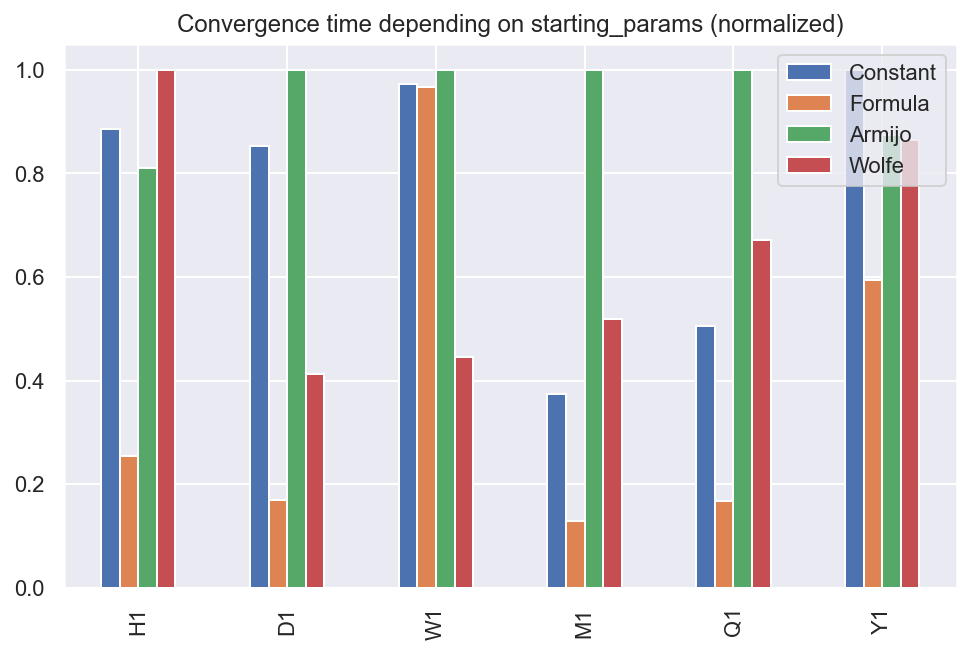

In [23]:
fh = np.array([5])
choices = ['Constant', 'Formula', 'Armijo', 'Wolfe']
convergence_failures = {key: 0 for key in choices}
df_times = pd.DataFrame(index=choices, columns=columns)
for series in columns:
    y = dataset[series]
    y = y.dropna().to_numpy()
    train, test = temporal_train_test_split(y, test_size=5)
    times = []
    print(f"Processing series {series}")
    for lr_finder in choices:
        model = DynamicRegression(fh=[5], learning_steps=np.array([5]), ar_depth=1, max_iter=10)
        status, history = model.fit(train, trace=True, lr_finder=lr_finder)
        if status == 'iterations_exceeded':
            print(f"Series {series} did not converge with lr_finder {lr_finder}")
            print(f"Tolerance is {history['grad_norm'][-1] ** 2 / history['grad_norm'][0] ** 2}")
            convergence_failures[lr_finder] += 1
        times.append(history['time'][-1])
    df_times[series] = times
normalized_df_times = (df_times)/df_times.max()
ax1 = normalized_df_times.transpose().plot.bar()
ax1.set_title("Convergence time depending on starting_params (normalized)")

В пяти из шести случаев лучший вариант -- Formula, с `starting_alpha=5e-3`. Однозначно стоит брать этот вариант.